## Notebook for testing a detection probability heatmap for a single white dwarf
This is a test notebook which explains all the steps in total_detection_probability.py which is for execution with the whole catalogue. It can also be used to create a map of detection probability for a particular white dwarf.

**Ongoing issues**
+ Extra bin in SN values of Ranalli data - for now I have just removed the smallest bin

## Table of Contents <a class="anchor" id="top"></a>

* [Setup](#setup)
    + [Create a model white dwarf or choose one from the catalogue](#create)
* [Import Ranalli 2018 data](#data)
* [Create a map of signal](#step-1)
* [Detection probability](#step-2)
    + [Plot of detection probability](#detect-plot)
    + [Comments](#comments)
* [Optimisation](#optimisation)
* [Combine detection probability and planet occurrence rate](#step-3)
    + [Import planet occurrence rate](#import-data)
    + [Plot of number of detectable planets](#detectable-planets)
    + [Plot error](#error-analysis)

### Setup <a class="anchor" id="setup"></a>
<p align="right">(<a href="#top">back to top</a>)</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
mwd=0.6 #average mass of white dwarf [Msol]
msol=1.989e30 #mass of Sun [kg]
mj=1.898e27 #mass of Jupiter [kg

### Create a model WD or choose one from the catalogue <a class="anchor" id="create"></a>
<p align="right">(<a href="#top">back to top</a>)</p>


In [23]:
# these parameters are for G29-38
candidate = 'G29_38' #name of candidate, will be used in the filename so don't include illegal characters
d=17.5 #distance to WD [pc]
gmag =13.1 # Gaia broadband magnitude

In [5]:
# Calculate noise using equation 3, 4, 5
# same code as in Catalogue/noise_calculator.py
T_factor = 0.527

if 10**(0.4*(13-15))>10**(0.4*(gmag-15)):#replace values for which the second thing is bigger
    z=10**(0.4*(13-15)) 
else:
    z = 10**(0.4*(gmag-15))
    

sigma_pi = T_factor*(40+800*z+30*z**2)**(0.5)

noise = np.sqrt(150)*sigma_pi/(2.15*1.1)*1e-6  #sigma fov in as

## Import Ranalli 2018 data <a class="anchor" id="data"></a>
<p align="right">(<a href="#top">back to top</a>)</p>
The cell below comes from Ranalli, Piero, David Hobbs, and Lennart Lindegren. 2018. ‘Astrometry and Exoplanets in the Gaia Era: A Bayesian Approach to Detection and Parameter Recovery’. Astronomy & Astrophysics 614 (June): A30. https://doi.org/10.1051/0004-6361/201730921.

The data from Fig.5 in Ranalli et al. (2018) have been rebinned using rectangular bins, of size 0.059 in log(SN) and 0.75 in log(P). P is in units of years.

x contain log(SN), y contain log(P)

In [6]:
# read matrix and convert to numpy array
detfract10yr = pd.read_csv('detfract10yr.txt', sep=' ', header=14)
detfract10yr = detfract10yr.values
xedges10yr = np.array([-0.3  , -0.241, -0.182, -0.123, -0.064, -0.005,  0.054,  0.113, \
        0.172,  0.231,  0.29 ,  0.349,  0.408,  0.467,  0.526,  0.585, \
        0.644,  0.703,  0.762,  0.821,  0.88 ,  0.939,  0.998,  1.057])
yedges10yr = np.array([-1.1  , -1.025, -0.95 , -0.875, -0.8  , -0.725, -0.65 , -0.575, \
       -0.5  , -0.425, -0.35 , -0.275, -0.2  , -0.125, -0.05 ,  0.025, \
        0.1  ,  0.175,  0.25 ,  0.325,  0.4  ,  0.475,  0.55 ,  0.625, \
        0.7  ,  0.775,  0.85 ,  0.925,  1.   ,  1.075,  1.15 ,  1.225, \
        1.3  ,  1.375])

Examine the data (Ranalli wrote this bit)

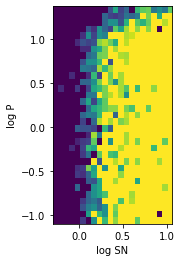

In [7]:
plt.imshow(detfract10yr.T, origin='lower', extent=[xedges10yr[0], xedges10yr[-1], yedges10yr[0], yedges10yr[-1]])
plt.xlabel('log SN')
plt.ylabel('log P')
plt.show()

Can see for S/N less than 1 the detection probability basically goes to 0.

Examine shape of data.
Xedges is too large and not sure which one is missing?

In [8]:
print(np.shape(detfract10yr.T))
print(len(yedges10yr))
print(len(xedges10yr))

(33, 22)
34
24


Convert P/yr edges to a/au edges

$\frac{a}{au}=\left(\frac{M_*}{M_\odot}\left(\frac{P}{year}\right)^2\right)^{\frac{1}{3}}$

In [9]:
#convert P edges to au
unlogP=10**yedges10yr
aedges10yr=(mwd*(unlogP)**2)**(1/3)
print(aedges10yr)
print(unlogP)

[0.15585369 0.17487071 0.19620817 0.22014919 0.24701145 0.2771514
 0.31096899 0.34891295 0.39148676 0.43925537 0.49285264 0.55298975
 0.62046471 0.69617285 0.78111879 0.87642969 0.98337029 1.10335961
 1.23798985 1.38904746 1.55853688 1.74870714 1.96208168 2.20149186
 2.47011449 2.77151404 3.1096899  3.48912946 3.91486764 4.39255374
 4.92852636 5.52989753 6.20464707 6.96172852]
[ 0.07943282  0.09440609  0.11220185  0.13335214  0.15848932  0.18836491
  0.22387211  0.26607251  0.31622777  0.3758374   0.44668359  0.53088444
  0.63095734  0.74989421  0.89125094  1.05925373  1.25892541  1.49623566
  1.77827941  2.11348904  2.51188643  2.98538262  3.54813389  4.21696503
  5.01187234  5.95662144  7.07945784  8.41395142 10.         11.88502227
 14.12537545 16.78804018 19.95262315 23.71373706]


Can see here the maximum period is much much longer than 10 years. In figure 5 of Ranalli et al. he doesn't even show the final few period points.
Make SN edges one shorter to match length of data - 
have removed the bottom edge as all the values at the bottom are zero anyway.

In [10]:
snedges10yr=xedges10yr[1:]
print(len(snedges10yr))

23


## Step 1: Create a map of $\alpha$ as a function of M and a <a class="anchor" id="step-1"></a>
<p align="right">(<a href="#top">back to top</a>)</p>

$\alpha = \frac{\frac{a}{au}\frac{M_{pl}}{M_*}}{\frac{d}{pc}}$

In [11]:
# choose a number of bins
#for now match with other heatmaps notebook
nbins_a=100
nbins_m=31

In [12]:
# create arrays for a and M
#for a use maximum in Ranalli period - [au]
a_min=min(aedges10yr)
a_max=max(aedges10yr)
#for M use maximum and minimum in simulation data [msol]
m_min=3.00348934885079e-06
m_max=0.0124097250416012 

a_in=np.linspace(a_min,a_max,nbins_a)
m_in=np.logspace(np.log10(m_min),np.log10(m_max),nbins_m) #returns planet masses evenly distributed in logspace in units of msol

In [13]:
#calculate alpha for d=1pc
noise_info=pd.DataFrame()
for i in range(len(m_in)):
    alpha_out=a_in*m_in[i]
    data_dict=pd.DataFrame({'logM':np.log10(m_in[i]*msol/mj),'a':a_in,'alpha':alpha_out})
    noise_info=noise_info.append(data_dict,ignore_index=True) #a in au, logM in Mj

Save as a csv so this map can be reused

In [14]:
#noise_info.to_csv('alpha_map.csv')

In [15]:
#scale for given WD
noise_info.loc[:,'SN']=noise_info['alpha'].copy()/(d*noise)

Create heatmap

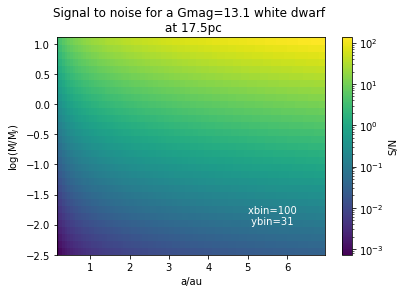

In [17]:
plt.figure()
plt.hist2d(noise_info['a'],noise_info['logM'],bins=[nbins_a,nbins_m],weights=noise_info['SN'],norm=mcolors.LogNorm())
plt.xlabel('a/au')
plt.ylabel('log(M/M$_J$)')
plt.title('Signal to noise for a Gmag={} white dwarf \n at {}pc'.format(gmag,d))
plt.text(5,-2,'xbin={} \n ybin={}'.format(nbins_a,nbins_m),color='white')
plt.colorbar(label='S/N')

## Step 2 - Create a map of detection probability <a class="anchor" id="step-2"></a>
<p align="right">(<a href="#top">back to top</a>)</p>

For each point in the map find the index for Ranalli's bins of corrresponding a and S/N

In [18]:
noise_info.loc[:,'a_index']=np.digitize(noise_info['a'],aedges10yr) #find index of bin it belongs to in a space
noise_info.loc[:,'sn_index']=np.digitize(np.log10(noise_info['SN']),snedges10yr) #find index of bin it belongs to in m space

In [19]:
#Things with S/N greater than max value will be given an index of 23
#These strong objects are still detectable so just relabel with second lowest index

noise_info.loc[(noise_info.a_index == (len(aedges10yr))),'a_index']=len(aedges10yr)-1
noise_info.loc[(noise_info.sn_index == (len(snedges10yr))),'sn_index']=len(snedges10yr)-1

#things outside of range will move into smallest bin as value in this bin is 0 anyway
noise_info.loc[(noise_info.a_index == 0),'a_index']=1
noise_info.loc[(noise_info.sn_index == 0),'sn_index']=1

Use these indices to create a new column for detection probability at each point

Have to minus 1 as bin count starts from 1 for data in range



In [20]:
noise_info.loc[:,'prob_detect']=detfract10yr[noise_info['sn_index']-1,noise_info['a_index']-1] 

### Plot of detection probability <a class="anchor" id="detect-plot"></a>
<p align="right">(<a href="#top">back to top</a>)</p>
This is Figure 3 in the paper and can also make a plot of detection probability for your given candidate.

In [22]:
import seaborn as sns

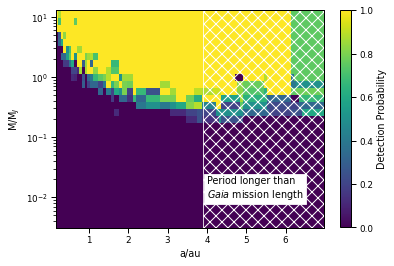

In [24]:
#define M bins are equal in log space
mbins_log=np.histogram_bin_edges(noise_info['logM'],nbins_m) #equal bins in log space
mbins_unlog=10**mbins_log
noise_info.loc[:,'M']=10**noise_info['logM'].copy()

with sns.plotting_context('paper'):
    plt.figure()
    plt.hist2d(noise_info['a'],noise_info['M'],bins=[nbins_a,mbins_unlog],weights=noise_info['prob_detect'],)
    plt.fill_between([3.91,max(a_in)],min(noise_info['M']),max(noise_info['M']),hatch='xx',color="none",edgecolor='white')
    plt.xlabel('a/au')
    plt.ylabel('M/M$_J$')
    plt.yscale('log')
    plt.text(4,1e-2,'Period longer than \n$\it{Gaia}$ mission length',color='black',bbox=dict(boxstyle='square', fc="w", ec="w",alpha=1))
    plt.colorbar(label='Detection Probability')
    plt.savefig('detection_probability_{}.pdf'.format(candidate),bbox_inches='tight')

## Step 3 - Combine detection probability with planet occurrence <a class="anchor" id="step-3"></a>
<p align="right">(<a href="#top">back to top</a>)</p>

If you are looking at a specific candidate do not go through this step. This just tests the code that is applied to the whole catalogue.
The planet occurrence map is the same for all white dwarfs so can multiply this to the sum of all the maps at the end. Need to rebin the data so the edges match that of the distribution, which has been binned to match the detection probabilities in Ranalli et al. (2018).

### Import the data <a class="anchor" id="import-data"></a>
<p align="right">(<a href="#top">back to top</a>)</p>


In [ ]:
hist_val_wd=np.loadtxt('../Distribution/wd_distribution.csv',delimiter=',')
error_val_wd=np.loadtxt('../Distribution/error_distribution.csv',delimiter=',')
a_edges_wd=np.loadtxt('../Distribution/wd_a_edges.csv',delimiter=',')
m_edges_wd=np.loadtxt('../Distribution/wd_m_edges.csv',delimiter=',')

Rebin noise info with matching edges

In [ ]:
prob_hist, a_edges, m_edges=np.histogram2d(noise_info['a'],noise_info['logM'],weights=noise_info['prob_detect'],bins=[a_edges_wd,m_edges_wd])

In [ ]:
num_planets=np.multiply(prob_hist,hist_val_wd)

### Plot of number of detectable planets <a class="anchor" id="detectable-planets"></a>
<p align="right">(<a href="#top">back to top</a>)</p>

In [ ]:
plt.figure()
plt.pcolormesh(a_edges,m_edges,np.transpose(num_planets),norm=mcolors.LogNorm(),shading='flat')
plt.xlabel('a/au')
plt.ylabel('log(M/M$_J$)')
plt.title('Number of detected planets for a Gmag=15 white dwarf \n at {}pc'.format(d))
plt.colorbar(label='Number of detected planets')

Do same for the error

In [ ]:
error_planets=np.multiply(prob_hist,error_val_wd)

Find the proportional uncertainty

In [ ]:
mask=num_planets!=0
prop_error=np.zeros(np.shape(num_planets))
np.divide(error_planets,num_planets,out=prop_error,where=mask)

### Error Analysis
<a class="anchor" id="error-analysis"></a>
<p align="right">(<a href="#top">back to top</a>)</p>

In [ ]:
plt.figure(figsize=[10,5],tight_layout=True)
plt.subplot(1,2,1)
plt.pcolormesh(a_edges,m_edges,np.transpose(num_planets),norm=mcolors.LogNorm(),shading='flat')
plt.xlabel('a/au')
plt.ylabel('log(M/M$_J$)')
plt.title('Number of detected planets')
plt.colorbar(label='Number of detected planets')

plt.subplot(1,2,2)
plt.pcolormesh(a_edges,m_edges,np.transpose(prop_error),shading='flat',norm=mcolors.LogNorm())
plt.xlabel('a/au')
plt.ylabel('log(M/M$_J$)')
#plt.xlim([0,4])
plt.title('Propotional error in number of detected planets')
plt.colorbar(label='Proportional error')
plt.suptitle('Number of detected planets and error for a G$_{mag}$=15 white dwarf at 30 pc')
#plt.savefig('Initial_error_graph.png')